## Access Autonomous Underwater Vehicle data in Parquet
A jupyter notebook to show how to access and plot the AODN autonomous_underwater_vehicle dataset available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/af5d0ff9-bb9c-4b7c-a63c-854a630b6984).

In [1]:
dataset_name = "autonomous_underwater_vehicle"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys
import platform

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():  # For Google Colab
    import xarray as xr
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
    os.system('uv pip install --system pyopenssl --upgrade')
elif 'jupyter' in platform.uname().node:  # For Nectar Instance https://jupyterhub.rc.nectar.org.au
    os.system(f'uv pip install --system -r {requirements_path}')
else: # If running locallly
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.10 interpreter at: /home/lbesnard/miniforge3/envs/CO_test/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Using Python 3.12.10 environment at: /home/lbesnard/miniforge3/envs/CO_test
Audited 240 packages in 33ms


In [3]:
import requests
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [4]:
from DataQuery import GetAodn

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

NameError: name 'pq' is not defined

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 78.7 ms, sys: 18 ms, total: 96.6 ms
Wall time: 6.59 s


In [7]:
aodn_dataset.dataset.partitioning.schema

campaign_name: string
dive_name: string
timestamp: int32
polygon: string

## List unique partition values

In [8]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('campaign_name')
print(list(unique_partition_value)[0:10])  # showing a subset only

['SEQueensland201210', 'DiscoveryBay202112', 'SolitaryIs201208', 'TasVic201602SS', 'SAJosephBanks200806', 'WA_SW_202103', 'GBR200709', 'Ningaloo201203', 'WA201304', 'Ningaloo201709']
CPU times: user 7.05 ms, sys: 1.43 ms, total: 8.49 ms
Wall time: 6.26 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/CO_test/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:580: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:580: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


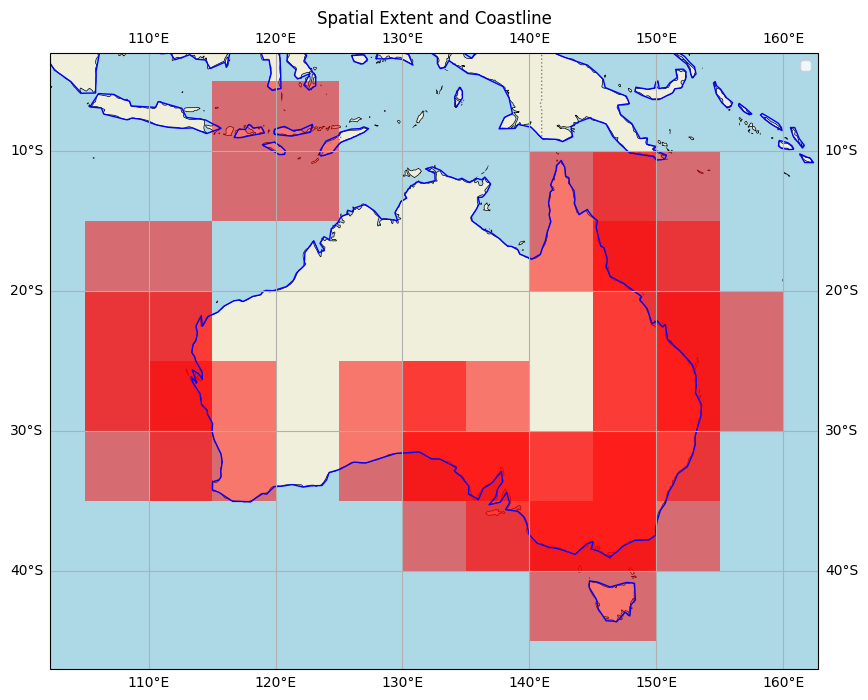

In [9]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

In [10]:
aodn_dataset.get_temporal_extent()

(Timestamp('2007-09-28 01:40:25.568000'),
 Timestamp('2023-10-11 02:09:54.375719936'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [11]:
metadata = aodn_dataset.get_metadata()
metadata

{'timestamp': {'type': 'int64'},
 'polygon': {'type': 'string'},
 'filename': {'type': 'string'},
 'campaign_name': {'type': 'string'},
 'dive_name': {'type': 'string'},
 'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0,
  'valid_max': 90000.0,
  'comments': 'Time synchronised before diving. There after standard PC clock',
  'quality_control_set': 1,
  'quality_control_indicator': 1,
  'uncertainty': 1.1574074074074073e-05,
  'local_time_zone': '+8'},
 'LATITUDE': {'type': 'double',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'comments': 'Initial pos from GPS, thereafter position data is generated using SLAM image based naviagation. Relative uncertainty much smaller that the absolute uncertainty quoted here.',
  'quality_control_set': 1,
  'quality_control_indicator': 1,
  'uncertainty': '20m circle',
  'reference': 'ge

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [12]:
filter_time = create_time_filter(parquet_ds, date_start='2021-12-01', date_end='2021-12-01 23:00:00')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-39, lat_max=-38, lon_min=141, lon_max=142)



filter = filter_geo & filter_time

NameError: name 'create_time_filter' is not defined

In [ ]:
%%time
df = aodn_dataset.get_data(date_start='2021-12-01', date_end='2021-12-01 23:00:00', lat_min=-39, lat_max=-38, lon_min=141, lon_max=142)
df.info()

In [ ]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df.info()

In [ ]:
df

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))

# Plot the time series
plt.plot(df['TIME'], df['TEMP'], label='CDOM', color='blue')

# Formatting the plot
plt.xlabel('Time')
plt.ylabel('TEMP')
plt.title('Sea Water Temperature Timeseries')
plt.grid(True)
plt.legend()

# Formatting the x-axis for date display
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import gsw  # TEOS-10 library

from DataQuery import plot_ts_diagram
plot_ts_diagram(df)

## Create a TIME and scalar/number filter

In [ ]:
%%time
df = aodn_dataset.get_data(scalar_filter = {'campaign_name': "DiscoveryBay202112"})
df.info()

In [ ]:
filtered_df = df[(df['PSAL'] >= 30)]

plot_ts_diagram(filtered_df)